In [1]:
import json, os
import numpy as np
import matplotlib.pyplot as plt
def read_json(pth):
    assert os.path.exists(pth)
    with open(pth) as fp:
        return json.load(fp)

def to_json(obj, pth):
    with open(pth, "w") as fp:
        json.dump(obj, fp)
from collections import defaultdict
edist = lambda x1, y1, x2, y2: np.sqrt((x1 + x2)**2 + (y1 + y2)**2)
from mpl_toolkits.mplot3d import Axes3D



In [2]:
preds = read_json("data/output/1RchFn-zZDw-results.json")

print(preds[0].keys())
for pred in preds:
    print(
        pred['image_id'],
        pred['category_id'],
        np.array(pred['keypoints']).shape,
        pred['score'],
        np.array(pred['box']),
        pred['idx'],
    )
    break


dict_keys(['image_id', 'category_id', 'keypoints', 'score', 'box', 'idx'])
0.jpg 1 (51,) 3.1060922145843506 [533.31903076 268.63006592 243.50982666 263.4899292 ] [0.0]


10
Hip 6.16613037109375 5.617908935546875 4.340333251953125 4.243588256835937 19.15641956588427 22.395340642332478
Shoulder 7.133580322265625 6.488613891601562 4.469326477050781 4.469326477050781 24.9868872495749 6.221026387184205
42
Hip 6.518563842773437 6.05185791015625 5.2792901611328125 5.306743469238281 15.795190452468326 19.601164157394372
Shoulder 6.985269165039062 6.298937377929687 4.400785217285156 4.483145141601563 23.71555840369193 4.501156833162189
120
Hip 6.376588134765625 5.87267822265625 4.356703186035157 4.356703186035157 18.017052837209707 21.33511648623454
Shoulder 6.4682080078125 5.826868286132813 3.0282136535644533 2.936593627929687 27.24551881361363 5.604788074203024
210
Hip 6.670402221679687 6.175484619140625 4.896525268554687 4.84703369140625 13.785280548768622 17.741173782430828
Shoulder 6.868368530273438 6.224976196289062 3.510757141113281 3.560248870849609 25.296931239332864 4.783042156183923
240
Hip 6.485938720703125 6.033391723632812 4.957334899902344 4.9573

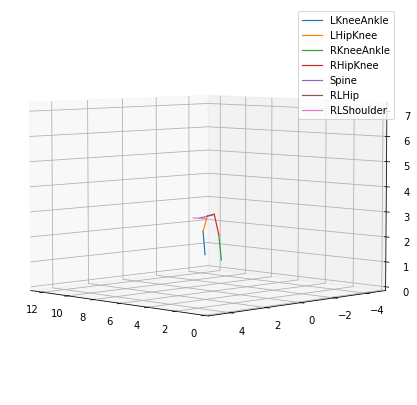

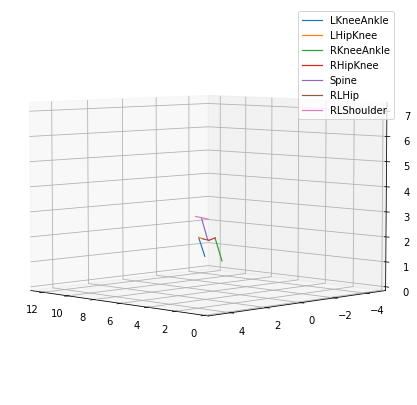

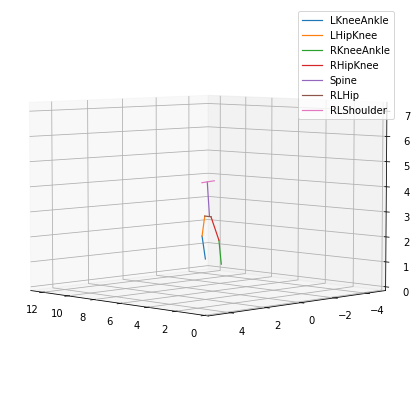

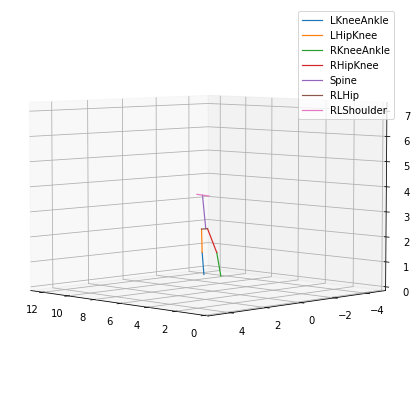

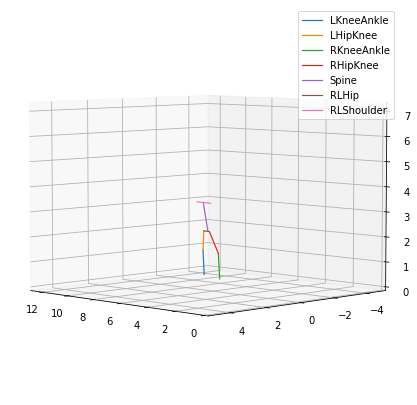

In [63]:
gt_labels = {
        "Nose"          : np.array([0], dtype=int),
        "LEye"          : np.array([1], dtype=int),
        "REye"          : np.array([2], dtype=int),
        "LEar"          : np.array([3], dtype=int),
        "REar"          : np.array([4], dtype=int),
        "LShoulder"     : np.array([5], dtype=int),
        "RShoulder"     : np.array([6], dtype=int),
        "LElbow"        : np.array([7], dtype=int),
        "RElbow"        : np.array([8], dtype=int),
        "LWrist"        : np.array([9], dtype=int),
        "RWrist"        : np.array([10], dtype=int),
        "LHip"          : np.array([11], dtype=int),
        "RHip"          : np.array([12], dtype=int),
        "LKnee"         : np.array([13], dtype=int),
        "RKnee"         : np.array([14], dtype=int),
        "LAnkle"        : np.array([15], dtype=int),
        "RAnkle"        : np.array([16], dtype=int),

}

joints = {
        "LArm_joint" : ["LWrist", "LElbow", "LShoulder"],
        "RArm_joint" : ["RWrist", "RElbow", "RShoulder"],
        "LLeg_joint" : ["LAnkle", "LKnee", "LHip"],
        "RLeg_joint" : ["RAnkle", "RKnee", "RHip"],
}

joint_length = {
        ("Knee", "Ankle")        : 19.383904646082087,
        ("Hip", "Knee")          : 18.75865770668652,
        ("Shoulder", "Hip")      : 18.10050979847486,
        ("Shoulder", "Shoulder") : 17.533904275404254,
        ('Shoulder', 'Elbow')    : 18.527060682086027,
        ('Elbow', 'Wrist')    : 18.374696078795736,
}

# Knee Ankle 19.383904646082087
# Hip Knee 18.75865770668652
# Shoulder Hip 18.10050979847486

ROT = lambda theta: np.array([
        [np.cos(theta), -1 * np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1],
])

class Skeleton:
        def get_angle(self, ptA, ptB, ptC):
                dist = lambda x, y: torch.dist(x, y, p=2)
                lnAB = dist(ptA, ptB)
                lnBC = dist(ptB, ptC)
                lnAC = dist(ptA, ptC)
                theta = np.arccos(((lnAB**2) + (lnBC**2) - (lnAC**2)) / (2 * lnAB * lnBC))
                return np.degrees(theta)

        def add_centroids(self, d):
                for key in ['Hip', 'Ankle', 'Knee', 'Shoulder', 'Wrist']:
                        d[f"C{key}"] = (d[f"L{key}"] + d[f"R{key}"]) / 2
                return d
                
        def add_angles(self, d):
                # Use law of cosines.
                for j, (ka, kb, kc) in joints.items():
                        d[j] = self.get_angle(d[ka], d[kb], d[kc])
                return d
        
        def calc_z_val(self, x1, y1, x2, y2, xx, yy):
                proj_length = np.sqrt((x1 + x2)**2 + (y1 + y2)**2)
                true_length = joint_length[(xx, yy)]
                return -1 * ((true_length ** 2) - (proj_length ** 2)) ** 0.5
                
        def calc_gamma(self, x1, y1, x2, y2, xx, yy):
                proj_length = np.sqrt((x1 + x2)**2 + (y1 + y2)**2)
                true_length = joint_length[(xx, yy)]
                return np.rad2deg(np.arccos(proj_length / true_length))
                # return 0
        
        def calc_dir_facing(self):
                # The Knee Angle will always be perpendicular to direction facing.
                # Get left knee angle.
                dir = "R"
                x1, y1, _ = (self.feat_dict[dir+"Hip"])
                x2, y2, _ = (self.feat_dict[dir+"Knee"])
                left_gamma = self.calc_gamma(x1, y1, x2, y2, "Hip", "Knee")
                dir = "L"
                x1, y1, _ = (self.feat_dict[dir+"Hip"])
                x2, y2, _ = (self.feat_dict[dir+"Knee"])
                right_gamma = self.calc_gamma(x1, y1, x2, y2, "Hip", "Knee")

                gamma = (left_gamma + right_gamma) / 2
                return gamma + 90

        def plot(self, plot_3d=False):
                fig = plt.figure(figsize=(12.70, 7.20))
                if plot_3d:
                        ax = fig.add_subplot(111, projection='3d')
                else:
                        ax = fig.add_subplot(111)
                ax.set_ylim([0, 7.20])
                ax.set_xlim([0, 12.70])
                if plot_3d:
                        ax.set_xlim([0, 12.70])
                        ax.set_zlim([0, 7.20])
                        ax.set_ylim([-5, 5])
                        ax.view_init(azim=90+45, elev=5)

                # for k, v in self.feat_dict.items():

                # Calc and Plot direction facing.
                gamma = self.calc_dir_facing()
                x, y, _ = self.feat_dict["CAnkle"]
                y = abs(7.20 - y)
                # ax.plot([x, x + np.sin(np.deg2rad(gamma)) ], [y, y + np.cos(np.deg2rad(gamma))], linewidth=1.2, label="facing direction")
                z_feat = {}
                # Assume Z value for LAnkle = 0.
                z_LAnkle = 0.0
                x_LAnkle, y_LAnkle, _ = (self.feat_dict["LAnkle"])
                z_feat['LAnkle'] = (x_LAnkle, y_LAnkle, z_LAnkle)

                # Get Z value for RAnkle
                x_RAnkle, y_RAnkle, _ = (self.feat_dict["RAnkle"])
                z_RAnkle = (edist(x_LAnkle, y_LAnkle, x_RAnkle, y_RAnkle)) / np.cos(np.deg2rad(gamma))
                z_feat['RAnkle'] = (x_RAnkle, y_RAnkle, z_RAnkle)

                # Get Z value for Right Knee.
                x_RKnee, y_RKnee, _ = (self.feat_dict["RKnee"])
                proj_len = edist(x_RKnee, y_RKnee, x_RAnkle, y_RAnkle)
                true_len = joint_length[("Knee", "Ankle")]
                z_RKnee = ((true_len**2) - (proj_len**2))**0.5
                z_feat['RKnee'] = (x_RKnee, y_RKnee, z_RKnee + z_RAnkle)

                # Get Z value for Left Knee.
                x_LKnee, y_LKnee, _ = (self.feat_dict["LKnee"])
                proj_len = edist(x_LKnee, y_LKnee, x_LAnkle, y_LAnkle)
                true_len = joint_length[("Knee", "Ankle")]
                z_LKnee = ((true_len**2) - (proj_len**2))**0.5
                z_feat['LKnee'] = (x_LKnee, y_LKnee, z_LKnee + z_LAnkle)


                # Get Z value for right hip.
                x_RHip, y_RHip, _ = (self.feat_dict["RHip"])
                proj_len = edist(x_RHip, y_RHip, x_RKnee, y_RKnee)
                true_len = joint_length[("Hip", "Knee")]
                z_RHip = ((true_len**2) - (proj_len**2))**0.5
                z_feat['RHip'] = (x_RHip, y_RHip, z_RHip + z_RKnee)

                # Get Z value for left hip.
                x_LHip, y_LHip, _ = (self.feat_dict["LHip"])
                proj_len = edist(x_LHip, y_LHip, x_LKnee, y_LKnee)
                true_len = joint_length[("Hip", "Knee")]
                z_LHip = ((true_len**2) - (proj_len**2))**0.5
                z_feat['LHip'] = (x_LHip, y_LHip, z_LHip + z_LKnee)
                
                # Can now infer location of center hip.
                x_CHip, y_CHip, z_CHip = (*self.feat_dict["CHip"][:2], (z_LHip + z_RHip) / 2)
                z_feat['CHip'] = (x_CHip, y_CHip, z_CHip)

                # Get Z value for center shoulder using center hip
                x_CShoulder, y_CShoulder, _ = (self.feat_dict["CShoulder"])
                proj_len = edist(x_CShoulder, y_CShoulder, x_CHip, y_CHip)
                true_len = joint_length[("Shoulder", "Hip")]
                z_CShoulder = ((true_len**2) - (proj_len**2))**0.5
                z_feat['CShoulder'] = (x_CShoulder, y_CShoulder, z_CHip + z_CShoulder)                
                # get Z value for left shoulder using center shoulder.
                x_LShoulder, y_LShoulder, _ = (self.feat_dict["LShoulder"])
                x_RShoulder, y_RShoulder, _ = (self.feat_dict["RShoulder"])
                proj_len = edist(x_LShoulder, y_LShoulder, x_RShoulder, y_RShoulder) / 2
                true_len = joint_length[("Shoulder", "Shoulder")]
                z_LShoulder = ((true_len**2) - (proj_len**2))**0.5
                z_feat['LShoulder'] = (x_LShoulder, y_LShoulder, z_CShoulder + z_LShoulder)

                # get Z value for right shoulder using center shoulder.
                proj_len = edist(x_LShoulder, y_LShoulder, x_RShoulder, y_RShoulder) / 2
                true_len = joint_length[("Shoulder", "Shoulder")] / 2
                z_RShoulder = ((true_len**2) - (proj_len**2))**0.5
                z_feat['RShoulder'] = (x_RShoulder, y_RShoulder, z_CShoulder - z_RShoulder)

                # Just to check, lets try to recover the left and right shoulder from the dir_facing
                gamma = self.calc_dir_facing()
                x, y, _ = self.feat_dict["CShoulder"]
                y = abs(7.20 - y)
                # ax.plot([x, x + np.sin(np.deg2rad(gamma)) ], [y, y + np.cos(np.deg2rad(gamma))], linewidth=1.2, label="facing direction")



                if plot_3d:                
                        for dir in ['L', 'R']:
                                for (xx, yy) in [('Knee', 'Ankle'), ('Hip', 'Knee')]: # ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')
                                        x1, y1, z1 = (z_feat[dir+xx])
                                        x2, y2, z2 = (z_feat[dir+yy])
                                        # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                                        # gamma = self.calc_gamma(x1, y1, x2, y2, xx, yy)
                                        y1 = abs(7.20 - y1)
                                        y2 = abs(7.20 - y2)
                                        ax.plot(xs=[x1, x2], ys=[z1 / 100, z2 / 100], zs=[y1, y2],  linewidth=1.2, label=dir+xx+yy)

                        x1, y1, z1 = (z_feat["CHip"])
                        x2, y2, z2 = (z_feat["CShoulder"])
                        # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                        y1 = abs(7.20 - y1)
                        y2 = abs(7.20 - y2)
                        ax.plot(xs=[x1, x2], ys=[z1 / 100, z2 / 100], zs=[y1, y2],  linewidth=1.2, label="Spine")

                        for (xx, yy) in [('Hip', 'Hip'), ('Shoulder', 'Shoulder')]:
                                x1, y1, z1 = (z_feat["L"+xx])
                                x2, y2, z2 = (z_feat["R"+yy])
                                print(xx, x1, x2, y1, y2, z1, z2)
                                # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                                y1 = abs(7.20 - y1)
                                y2 = abs(7.20 - y2)
                                ax.plot(xs=[x1, x2], ys=[z1 / 100, z2 / 100], zs=[y1, y2],  linewidth=1.2, label="RL" + xx)


                ax.legend()

                # for dir in ['L', 'R']:
                #         for (xx, yy) in [('Knee', 'Ankle'), ('Hip', 'Knee'), ('Shoulder', 'Elbow'), ('Elbow', 'Wrist')]: # ('Elbow', 'Wrist'), ('Shoulder', 'Elbow')
                #                 x1, y1, _ = (self.feat_dict[dir+xx])
                #                 x2, y2, _ = (self.feat_dict[dir+yy])
                #                 z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                #                 # gamma = self.calc_gamma(x1, y1, x2, y2, xx, yy)
                #                 y1 = abs(7.20 - y1)
                #                 y2 = abs(7.20 - y2)
                #                 ax.plot([x1, x2], [y1, y2], linewidth=1.2, label=dir+xx+yy+str(z_val.round(2)))
                #         # if all(kk not in k for kk in ['Hip', 'Knee', 'Ankle']): continue
                #         # ax.scatter(v[0], v[1], label=k)
                
                # x1, y1, _ = (self.feat_dict["CShoulder"])
                # x2, y2, _ = (self.feat_dict["CHip"])
                # # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                # y1 = abs(7.20 - y1)
                # y2 = abs(7.20 - y2)
                # ax.plot([x1, x2], [y1, y2], linewidth=1.2, label="CShoulderHip")


                # for (xx, yy) in [('Hip', 'Hip'), ('Shoulder', 'Shoulder')]:
                #         x1, y1, _ = (self.feat_dict["L"+xx])
                #         x2, y2, _ = (self.feat_dict["R"+yy])
                #         # z_val = self.calc_z_val(x1, y1, x2, y2, xx, yy)
                #         y1 = abs(7.20 - y1)
                #         y2 = abs(7.20 - y2)
                #         ax.plot([x1, x2], [y1, y2], linewidth=1.2, label=dir+xx+yy)

        
        def __init__(self, arr):
                raw_input = np.array(arr).reshape(-1, 3)
                self.feat_dict = {k : (raw_input[v.item()] / 100 ) + [0, 1.2, 0]  for (k, v) in gt_labels.items()}
                self.feat_dict = self.add_centroids(self.feat_dict)
                # self.feat_dict = self.add_angles(self.feat_dict)
                # print(self.feat_dict)
                

# Skeleton(preds[1]['keypoints']).plot()
for kp in [10, 42, 120, 210, 240]:
        print(kp)
        # Skeleton(preds[kp]['keypoints']).plot()
        Skeleton(preds[kp]['keypoints']).plot(plot_3d=True)
        
# Skeleton(preds[-30]['keypoints']).plot()


In [54]:

max_dist = defaultdict(float)
for i in range(len(preds)):
    s = Skeleton(preds[i]['keypoints'])
    # print(s.calc_dir_facing())
    x1, y1, _ = s.feat_dict["L" + "Shoulder"]
    x2, y2, _ = s.feat_dict["R" + "Shoulder"]
    d = edist(x1, y1, x2, y2)
    max_dist[("L", "Shoulder", "Shoulder")] = max(max_dist[("L", "Shoulder", "Shoulder")], d)


    for dir in ['L', 'R']:
            for (j1, j2) in list(joint_length.keys()) + [('Shoulder', 'Elbow'), ('Elbow', 'Wrist')]:
                x1, y1, _ = s.feat_dict[dir + j1]
                x2, y2, _ = s.feat_dict[dir + j2]
                d = edist(x1, y1, x2, y2)
                max_dist[(dir, j1, j2)] = max(max_dist[(dir, j1, j2)], d)


# print(max_dist)
for (j1, j2) in list(joint_length.keys()) + [('Shoulder', 'Elbow'), ('Elbow', 'Wrist')]:
    print(j1, j2, max(max_dist[("L", j1, j2)], max_dist[("R", j1, j2)]))

max_dist

Knee Ankle 19.383904646082087
Hip Knee 18.75865770668652
Shoulder Hip 18.10050979847486
Shoulder Shoulder 17.658366059884862
Shoulder Elbow 18.527060682086027
Shoulder Elbow 18.527060682086027
Elbow Wrist 18.374696078795736


defaultdict(float,
            {('L', 'Shoulder', 'Shoulder'): 17.658366059884862,
             ('L', 'Knee', 'Ankle'): 19.247187497200205,
             ('L', 'Hip', 'Knee'): 18.50351923680869,
             ('L', 'Shoulder', 'Hip'): 18.10050979847486,
             ('L', 'Shoulder', 'Elbow'): 17.6164850723737,
             ('L', 'Elbow', 'Wrist'): 18.3006526643457,
             ('R', 'Knee', 'Ankle'): 19.383904646082087,
             ('R', 'Hip', 'Knee'): 18.75865770668652,
             ('R', 'Shoulder', 'Hip'): 17.920486583140164,
             ('R', 'Shoulder', 'Shoulder'): 17.409637260504937,
             ('R', 'Shoulder', 'Elbow'): 18.527060682086027,
             ('R', 'Elbow', 'Wrist'): 18.374696078795736})